# Compute correlation function with error bars using log-normal mocks

In [40]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction, setup_logging

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import generate_mock, split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [41]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [42]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
bias = 1.8

#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')

In [16]:
mocks_results = np.load(output_dir+catalog.name+'_1000_mocks_2PCF_rsd.npy', allow_pickle=True)

In [17]:
s = mocks_results[0].seps[0][:, 0]

## Compute covariance matrix

In [22]:
ells = [0, 2]
nells = len(ells)

xiell, cov = get_poles(mocks_results, ells)

## Plot correlation function with error bars

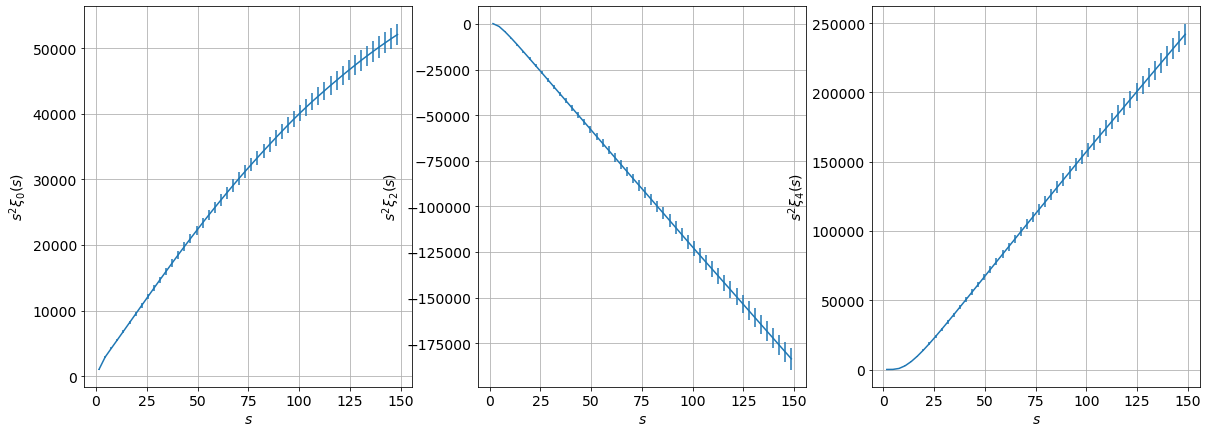

In [23]:
std = np.array_split(np.diag(cov)**0.5, nells)

plt.rcParams["figure.figsize"] = (20, 7)

fig, axes = plt.subplots(1, nells)

for ill,ell in enumerate(ells):
    axes[ill].errorbar(s+ill*0.1, s**2 * xiell[ill], s**2 * std[ill], fmt='-')
    axes[ill].grid(True)
    axes[ill].set_xlabel(r'$s$')
    axes[ill].set_ylabel(r'$s^2 \xi_{}(s)$'.format(ell))
    
plt.show()